In [1]:
import pandas as pd
import numpy as np
import os
import re
import requests as r
from Bio import SeqIO
from io import StringIO
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

We need:
- a function that creates a histogram from a FI3D run
- a function that calculates the tag-coverage


In [2]:
def generate_tags(sequence, depth):
    tags = []
    for aa in range(len(sequence)- depth +1):
        tags.append(sequence[aa:aa+depth])
        tags.append(sequence[aa:aa+depth][::-1])
    return tags
def tag_coverage(sequence1, sequence2, depth):
    tags1 = generate_tags(sequence1, depth)
    tags2 = generate_tags(sequence2, depth)
    tag_count = 0
    for tag_a in tags1:
        for tag_b in tags2:
            if tag_a == tag_b:
                tag_count += 1
                break
    return tag_count / len(tags1)

In [3]:
def build_histogram(folder_path):
    
    baseUrl="http://www.uniprot.org/uniprot/"
    currentUrl=baseUrl+"P00921"+".fasta"
    response = r.post(currentUrl)
    cData=''.join(response.text)

    target = cData[cData.find("\n"):].replace("\n","")
    
    
    
    files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
    
    df = pd.DataFrame({"depth":[], "window_size":[], "placement":[], "scaled_ratio":[], "actual hits":[], "tag_coverage_of_1":[]})
    
    for file_name in files:
        file_path = os.path.join(folder_path, file_name)
        
        pattern = re.compile(r'_(\d+)_.*_(\d+).')
        matches = pattern.search(file_name)
        if matches:
            temp_csv = pd.read_csv(file_path)
            if len(temp_csv[" Protein"]) == 0:
                df_concat = pd.DataFrame({"depth":[int(matches.group(2))],
                                   "window_size":[int(matches.group(1))], 
                                          "placement":[51], 
                                          "scaled_ratio":[0], 
                                          "actual hits":[0], 
                                          "tag_coverage_of_1":[0]})
            else:
                #first id the position of P00921
                pos_count = 0
                for protein in temp_csv[" Protein"]:
                    if "P00921" in protein:
                        break
                    pos_count += 1
                if pos_count >= len(temp_csv[" Protein"]):
                    pos_count = 51
            
                #next get the scaled_ratio and #the actuall number of hits?
                if pos_count < len(temp_csv[" Protein"]):
                    scaled_ratio = temp_csv[" # matched peaks "][pos_count] / temp_csv[" # matched peaks "][0]
                    actual_hits = temp_csv[" # matched peaks "][pos_count]
                else:
                    scaled_ratio = 0
                    actual_hits = 0
                    
                    
                

                #generate tag coverage
                pattern2 = re.compile(r'\|([^|]+)\|')
                
                matches2 = pattern2.search(temp_csv[" Protein"][0])
                if matches:
                    currentUrl=baseUrl+matches2.group(1) +".fasta"
                    response = r.post(currentUrl)
                    cData=''.join(response.text)
                    query = cData[cData.find("\n"):].replace("\n","")
                    tag_cov  = tag_coverage(query, target, int(matches.group(2)))
                else:
                    tag_cov = 0
                    
                 
                df_concat = pd.DataFrame({"depth":[int(matches.group(2))],
                                   "window_size":[int(matches.group(1))],
                                   "placement":[pos_count],
                                   "scaled_ratio":[scaled_ratio],
                                    "actual hits":[actual_hits],
                                   "tag_coverage_of_1":[tag_cov]})
       
            df = pd.concat([df, df_concat], ignore_index = True)
    
            
    return df
        

In [4]:
histo = build_histogram("CA_eval").sort_values(by=["depth", "window_size"])

In [19]:
histo

,depth,window_size,placement,scaled_ratio,actual hits,tag_coverage_of_1
0,0.0,0.0,51.0,0.0,0.0,1.0
637,0.0,50.0,51.0,0.0,0.0,1.0
14,0.0,100.0,51.0,0.0,0.0,1.0
91,0.0,150.0,51.0,0.0,0.0,1.0
168,0.0,200.0,51.0,0.0,0.0,1.0
...,...,...,...,...,...,...
601,6.0,4800.0,0.0,1.0,3.0,1.0
608,6.0,4850.0,0.0,1.0,3.0,1.0
615,6.0,4900.0,0.0,1.0,3.0,1.0
622,6.0,4950.0,0.0,1.0,3.0,1.0


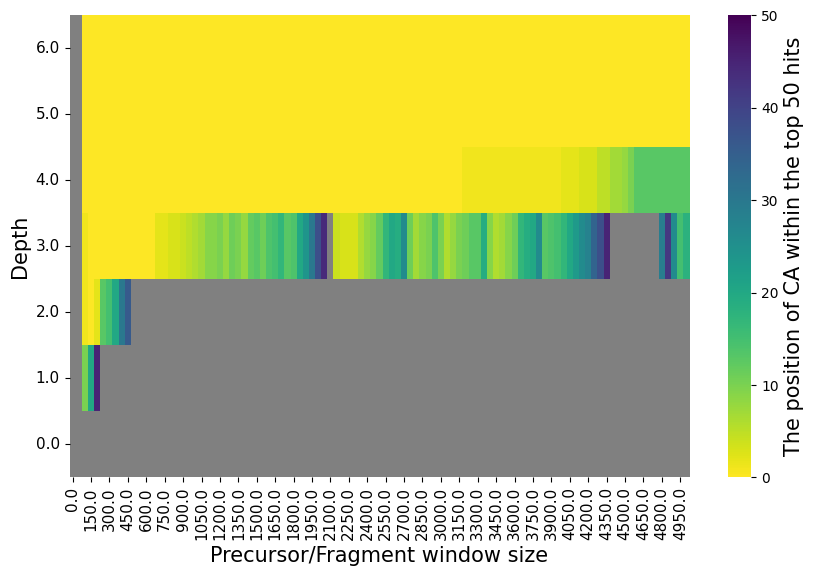

In [12]:

heatmap_data = histo.pivot('depth', 'window_size', 'placement')
hot_cold = sns.color_palette("YlOrBr", as_cmap=True).reversed()
plt.figure(figsize=(10, 6))

ax = sns.heatmap(heatmap_data, annot=False, cmap='viridis_r', vmax = 50, fmt=".2f", 
                 cbar_kws={'label': 'The position of CA within the top 50 hits'})

sns.heatmap(heatmap_data, 
            cmap=ListedColormap(['grey', 'grey', 'grey']), vmin=50, vmax=51, mask=heatmap_data < 50, cbar=False, ax=ax)
                           
cb = ax.collections[0].colorbar
cb.set_label('The position of CA within the top 50 hits', fontsize = 15)
plt.yticks(rotation=0, size = 11)
plt.xticks(rotation = 90, size = 11)
plt.gca().invert_yaxis()
ax.set_xlabel('Precursor/Fragment window size', fontsize = 15)
ax.set_ylabel('Depth', fontsize = 15)


plt.savefig("CA_position.png", bbox_inches = 'tight', dpi = 500)

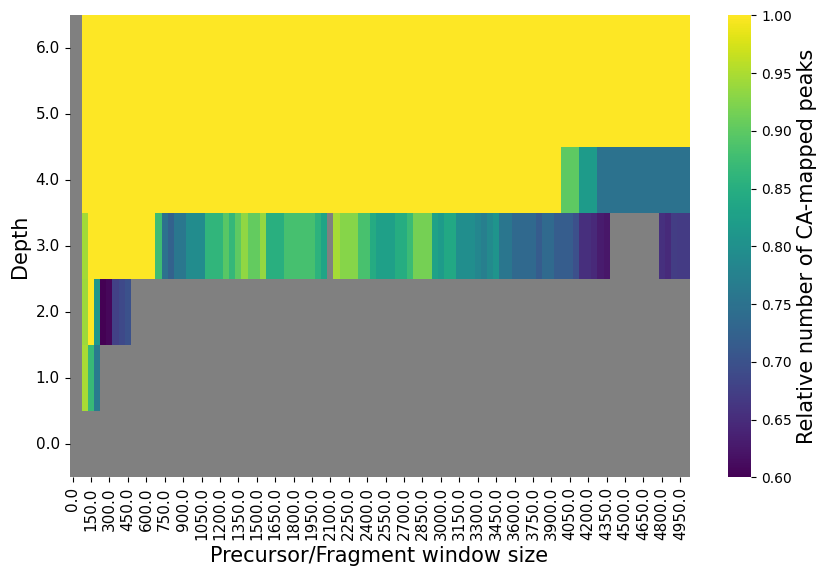

In [16]:
heatmap_data2 = histo.pivot('depth', 'window_size', 'scaled_ratio')
hot_cold = sns.color_palette("YlOrBr", as_cmap=True)
plt.figure(figsize=(10, 6))
ax = sns.heatmap(heatmap_data2, annot=False, cmap='viridis', fmt=".2f", mask = heatmap_data2 == 0,cbar_kws={'label': 'Relative number of CA-mapped peaks'})

ax.set_facecolor('grey')
plt.yticks(rotation=0, size = 11)
plt.xticks(rotation = 90, size = 11)
plt.gca().invert_yaxis()
cb = ax.collections[0].colorbar
cb.set_label('Relative number of CA-mapped peaks', fontsize = 15)
ax.set_xlabel('Precursor/Fragment window size', fontsize = 15)
ax.set_ylabel('Depth', fontsize = 15)

plt.savefig("CA_relative_hits.png", bbox_inches = 'tight', dpi = 500)

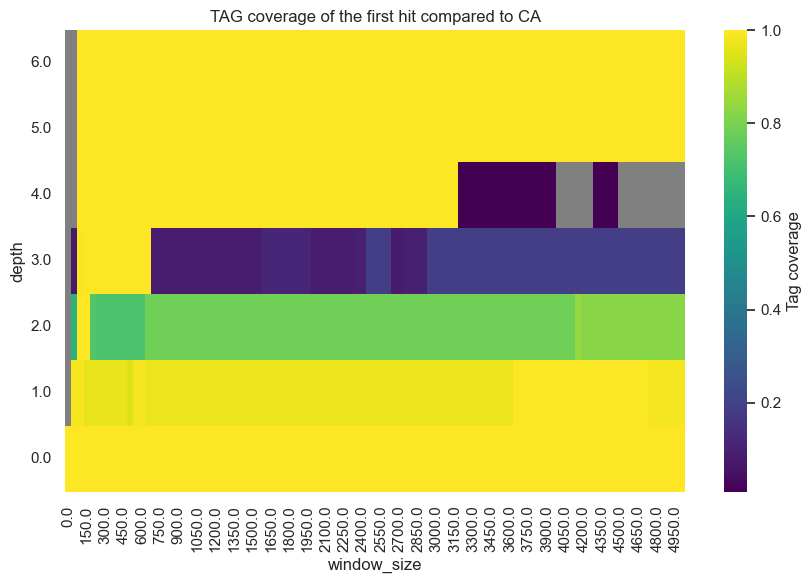

In [10]:
heatmap_data3 = histo.pivot('depth', 'window_size', 'tag_coverage_of_1')
hot_cold = sns.color_palette("YlOrBr", as_cmap=True)
plt.figure(figsize=(10, 6))
ax = sns.heatmap(heatmap_data3, annot=False, cmap='viridis', fmt=".2f", mask = heatmap_data3 == 0,cbar_kws={'label': 'Tag coverage'})

ax.set_facecolor('grey')
plt.yticks(rotation=0)
plt.gca().invert_yaxis()
plt.title('TAG coverage of the first hit compared to CA')
plt.show()

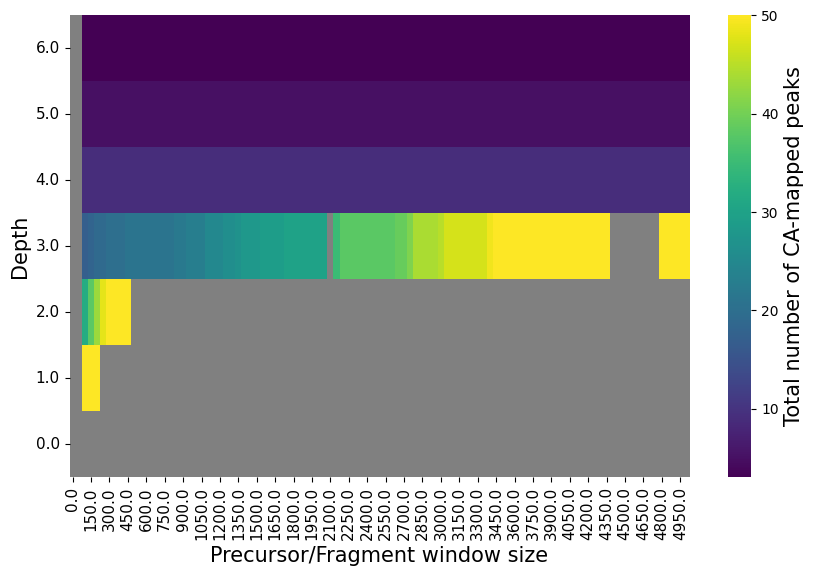

In [18]:
heatmap_data4 = histo.pivot('depth', 'window_size', 'actual hits')
hot_cold = sns.color_palette("YlOrBr", as_cmap=True)
plt.figure(figsize=(10, 6))
ax = sns.heatmap(heatmap_data4, annot=False, cmap='viridis', vmax = 50, fmt=".2f", mask = heatmap_data4 == 0,cbar_kws={'label': 'Total number of peaks that were mapped to CA'})

ax.set_facecolor('grey')
plt.yticks(rotation=0, size = 11)
plt.xticks(rotation = 90, size = 11)
plt.gca().invert_yaxis()
cb = ax.collections[0].colorbar
cb.set_label('Total number of CA-mapped peaks', fontsize = 15)
ax.set_xlabel('Precursor/Fragment window size', fontsize = 15)
ax.set_ylabel('Depth', fontsize = 15)

plt.savefig("CA_total_hits.png", bbox_inches = 'tight', dpi = 500)